## Blast chunks of genome to itself

Cut the honeybee genome into pieces then blast each piece onto the genome - ideally each piece should only match in one location but doing this we can see regions where there is a large mismatch! That is regions where parts of the genome from other places also map to that region. <br>

These are all aligner errors so knowing where they are is important!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as graph
from Bio import SeqIO
from tqdm import tqdm
from bisect import bisect
from itertools import chain
from collections import Counter
from IPython.display import display
from Helpers.iterators import for_groups
from Helpers.Graphing import PseudoPositions

In [2]:
# Make blast query file
fasta = '/data3/01_ngm_BQSR_haplotypecaller_VQSR/am45new.fasta'
output = 'blast_query_file_shift55.txt'
read_length = 115
shift = 55

with open(output, 'w+') as outfile:
    for record in tqdm(SeqIO.parse(fasta, 'fasta'), total=340):
        if float(record.id) > 17:
            continue
        
        chunks = for_groups(record.seq[shift:], read_length)
        for idx, group in enumerate(chunks):
            if len(group) >= read_length:
                start = idx * read_length + 1 + shift
                stop = start + read_length - 1

                outfile.write('>{}_{}_{}\n'.format(record.id, start, stop))
                outfile.write('{}\n'.format(group))
print('done')

5645it [00:14, 392.28it/s]                       

done


In [3]:
# Initialize pseudopositions
pp = PseudoPositions('/data4/ON/fastq/Training_set/am45new.fasta')

# Set read length filter
read_length = 115

def read_blast(file, thresh):
    # Read file
    df = pd.read_csv(file, sep='\t', header=None, dtype={1: object})
    df.columns = [
        'qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gap-open', 
        'qstart', 'qend', 'sstart', 'ssend', 'e-value', 'bitscore'
    ]
    
    # Modify columns
    df[['scaf', 'start', 'stop']] = df['qseqid'].str.split('_', expand=True)
    df['start'], df['stop'] = df['start'].astype(int), df['stop'].astype(int)
    df['chrom'] = df['scaf'].str.split('.').str.get(0).astype(int)
    df['diff'] = df['sstart'] - df['ssend']
    
    # Filter
    df = df[(df['pident'] >= thresh) & (df['length'] == read_length)]
    df['hash'] = df['sseqid'] + '_' + df['sstart'].astype(str) + '_' + df['ssend'].astype(str)
    df = df[df['qseqid'] != df['hash']]
    
    # Pseudopositions for graphing purposes
    df['starts_pp'] = df.apply(
        lambda row: pp.get(position=row['start'], scaffold=row['scaf']), axis=1)
    df['stops_pp'] = df.apply(
        lambda row: pp.get(position=row['stop'], scaffold=row['scaf']), axis=1)
    return df

In [4]:
df = read_blast('data/blast-output/blast_115_output_plus_strand.txt', 100)
display(df.head())

print('There are {} mismatches'.format(len(df)))
print('Percent mismatching in the forward direction: {}'.format(len(df[df['diff'] > 0]) / len(df)))

,qseqid,sseqid,pident,length,mismatch,gap-open,qstart,qend,sstart,ssend,e-value,bitscore,scaf,start,stop,chrom,diff,hash,starts_pp,stops_pp
369,1.1_19666_19780,1.1,100.0,115,0,0,1,115,20034,20148,1.000000e-54,213.0,1.1,19666,19780,1,-114,1.1_20034_20148,19666,19780
410,1.1_21851_21965,1.1,100.0,115,0,0,1,115,21568,21682,1.000000e-54,213.0,1.1,21851,21965,1,-114,1.1_21568_21682,21851,21965
608,1.1_31281_31395,1.1,100.0,115,0,0,1,115,31682,31796,1.000000e-54,213.0,1.1,31281,31395,1,-114,1.1_31682_31796,31281,31395
651,1.1_33351_33465,1.1,100.0,115,0,0,1,115,33453,33567,1.000000e-54,213.0,1.1,33351,33465,1,-114,1.1_33453_33567,33351,33465
660,1.1_33466_33580,1.1,100.0,115,0,0,1,115,33364,33478,1.000000e-54,213.0,1.1,33466,33580,1,-114,1.1_33364_33478,33466,33580


There are 55221 mismatches
Percent mismatching in the forward direction: 0.0


## Plot regions with mismatches

#### This visual overstates the number of mismatches for the sake of displaying the results

More than one mismatch: 451
Exactly one mismatch: 3151


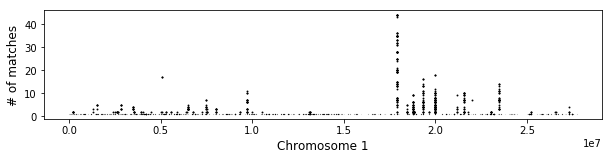

More than one mismatch: 92
Exactly one mismatch: 1802


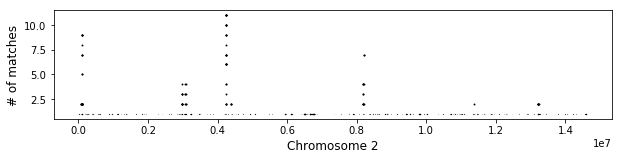

More than one mismatch: 81
Exactly one mismatch: 1342


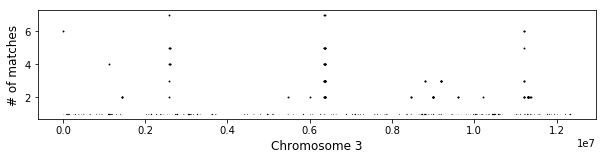

More than one mismatch: 139
Exactly one mismatch: 965


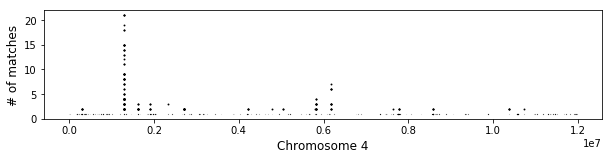

More than one mismatch: 102
Exactly one mismatch: 1063


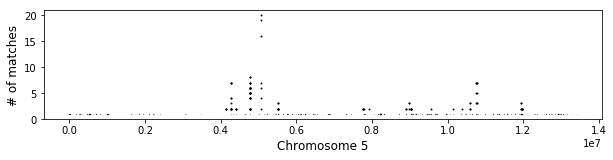

More than one mismatch: 520
Exactly one mismatch: 1929


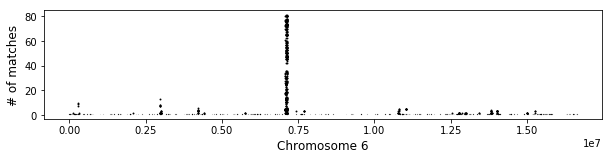

More than one mismatch: 201
Exactly one mismatch: 1528


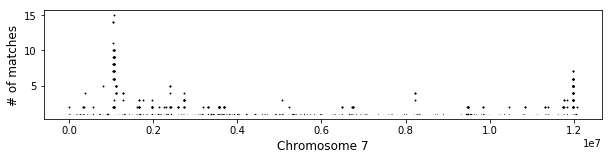

More than one mismatch: 180
Exactly one mismatch: 1358


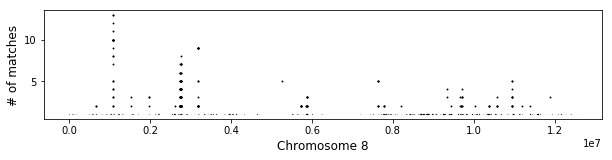

More than one mismatch: 125
Exactly one mismatch: 950


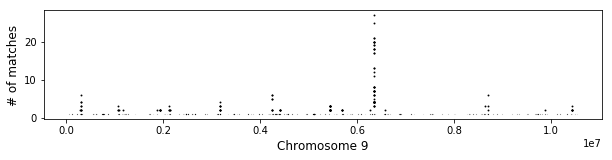

More than one mismatch: 684
Exactly one mismatch: 1335


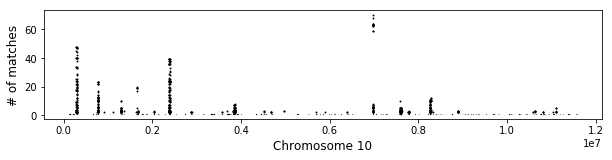

More than one mismatch: 263
Exactly one mismatch: 1717


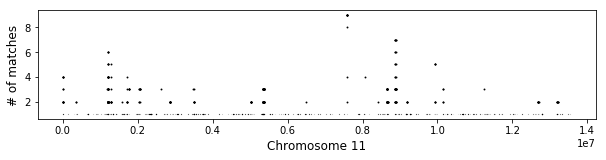

More than one mismatch: 163
Exactly one mismatch: 1345


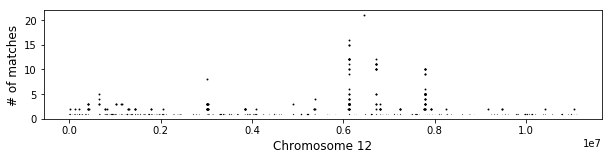

More than one mismatch: 163
Exactly one mismatch: 930


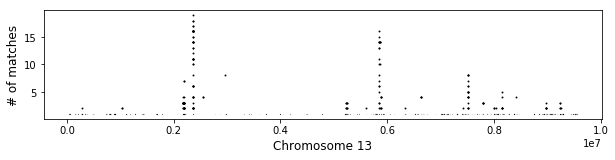

More than one mismatch: 76
Exactly one mismatch: 678


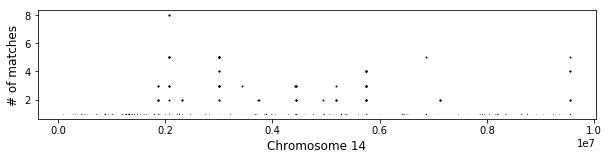

More than one mismatch: 60
Exactly one mismatch: 1363


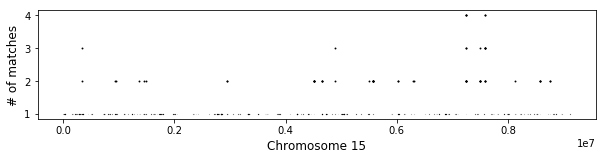

More than one mismatch: 153
Exactly one mismatch: 894


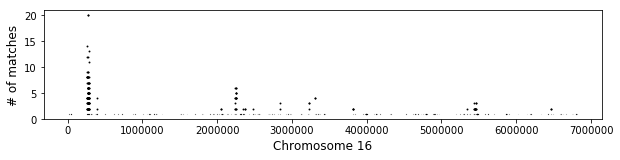

In [5]:
for chrom, df_i in df.groupby('chrom'):
    counter = Counter(df_i['starts_pp'])
    counter_large = Counter(pp for pp in counter.elements() if counter[pp] > 1)
    counter_small = Counter(pp for pp in counter.elements() if counter[pp] <= 1)
    
    print('More than one mismatch: {}'.format(len(counter_large)))
    print('Exactly one mismatch: {}'.format(len(counter_small)))
    
    # Graph where mismatches occur
    graph.figure(figsize=(10, 2))
    graph.plot(
        list(counter_large.keys()), list(counter_large.values()),
        'o', c='k', markersize=25000000/max(df['starts_pp']))
    graph.plot(
        list(counter_small.keys()), list(counter_small.values()), 
        'o', c='k', markersize=1000000/max(df['starts_pp']))
    graph.xlabel('Chromosome {}'.format(chrom), fontsize=12)
    graph.ylabel('# of matches', fontsize=12)
    graph.show()

# Check whether other sites are within these regions

In [24]:
# Finds if a position is in one of our windows
def snp_in_windows(chrom, pos):
    return True if bisect(ambigous_sites[chrom], pos) % 2 != 0 else False

df_unique = df.drop_duplicates(subset='qseqid')

# Aggregate starts and stops of ambigous sites by chromosome
ambigous_sites = {}
for chrom, df_i in df_unique.groupby('chrom'):
    ambigous_sites[chrom] = list(chain(
        *zip(df_i['starts_pp'], df_i['stops_pp'])
    ))
    assert sorted(ambigous_sites[chrom]) == ambigous_sites[chrom]
    assert len(ambigous_sites) == len(set(ambigous_sites))
    
# Test snp_in_windows
def get_positions(chrom, start, stop):
    return all([snp_in_windows(chrom, pos) for pos in range(start, stop)])

df['matches'] = df.apply(
    lambda row: get_positions(row['chrom'], row['starts_pp'], row['stops_pp']),
    axis=1
)

assert len(df['matches'].unique()) == 1 and df['matches'].unique()[0] == True

## Brocks blast results

### Check if these SNPs are also in the windows we find

In [ ]:
bb = pd.read_csv('/home/tanu/TRAINING_SET/putativeCNV.bed', sep='\t', dtype={0: object})
bb.columns = ['scaf', 'pos']

bb['chrom'] = bb['scaf'].str.split('.').str.get(0).astype(int)
bb['pp'] = bb.apply(
    lambda row: pp.get(position=row['pos'], scaffold=row['scaf']),
    axis=1
)

print('Number of SNPs: {}'.format(len(bb)))
display(bb.head())

In [ ]:
bb['matches'] = bb.apply(
    lambda row: snp_in_windows(row['chrom'], row['pp']), 
    axis=1
)

display(bb.groupby('matches').count())

##### Most of Brocks SNPs are not within our windows

## Are the shifted blast results also in the same region

In [ ]:
shift_df = read_blast('data/blast-output/blast_shift55_output_plus_strand.txt', 100)
shift_df.head()

In [ ]:
shift_df['matches'] = shift_df.apply(
    lambda row: snp_in_windows(row['chrom'], row['starts_pp']), 
    axis=1
)

display(shift_df.groupby('matches').count())

In [ ]:
check_me = shift_df[shift_df['matches'] == False]

In [ ]:
check_me['matches'] = check_me.apply(
    lambda row: snp_in_windows(row['chrom'], row['stops_pp']), 
    axis=1
)

display(check_me.groupby('matches').count())

In [ ]:
bb.head()

In [ ]:
for grp, df_i in bb.groupby('scaf'):
    df_i['diff'] = df_i['pos'].diff()
    df_i.fillna(0, inplace=True)
    
    graph.hist(df_i[df_i['diff'] < 100]['diff'], bins=25)
    graph.show()
    break

In [ ]:
def check_results(scaf, pos):
    subset = df[(df['scaf'] == scaf) & (df['start'] <= pos) & (df['stop'] >= pos)]
    return True if len(subset) else False

In [ ]:
bb[bb['matches'] == False].sample(5000).apply(
    lambda row: check_results(row['scaf'], row['pos']),
    axis=1
).unique()